<a href="https://colab.research.google.com/github/JimKing100/DS-Unit-2-Regression-Classification/blob/master/DSPT2_lesson_regression_classification_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Regression & Classification, Module 4


#### Objectives
- understand why overfitting is a problem and model validation is important
- begin with **baselines** for **classification**
- use classification metric: **accuracy**
- do **train/validate/test** split
- use scikit-learn for **logistic regression**

### Setup

You can work locally (follow the [local setup instructions](https://lambdaschool.github.io/ds/unit2/local/)) or on Colab (run the code cell below).

In [8]:
import os, sys
in_colab = 'google.colab' in sys.modules

# If you're in Colab...
if in_colab:
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification.git
    !git pull origin master
    
    # Install required python packages
    !pip install -r requirements.txt
    
    # Change into directory for module
    os.chdir('module4')

Reinitialized existing Git repository in /content/.git/
fatal: remote origin already exists.
From https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification
 * branch            master     -> FETCH_HEAD
Already up to date.


In [0]:
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

## Read data

The files are in the GitHub repository, in the `data/tanzania` folder:

 - `train_features.csv` : the training set features
 - `train_labels.csv` : the training set labels
 - `test_features.csv` : the test set features
 - `sample_submission.csv` :  a sample submission file in the correct format

#### Get started on Kaggle
1. [Sign up for a Kaggle account](https://www.kaggle.com/), if you don’t already have one. 
2. Go to our Kaggle InClass competition website. You will be given the URL in Slack.
3. Go to the Rules page. Accept the rules of the competition.


####  Alternative option to get data & make submissions: Kaggle API

1. Go to our Kaggle InClass competition webpage. Accept the rules of the competiton.

2. [Follow these instructions](https://github.com/Kaggle/kaggle-api#api-credentials) to create a Kaggle “API Token” and download your `kaggle.json` file.

3. Put `kaggle.json` in the correct location.

  - If you're using Anaconda, put the file in the directory specified in the [instructions](https://github.com/Kaggle/kaggle-api#api-credentials).

  - If you're using Google Colab, upload the file to your Google Drive, and run this cell:

  ```
  from google.colab import drive
  drive.mount('/content/drive')
  %env KAGGLE_CONFIG_DIR=/content/drive/My Drive/
  ```

4. [Install the Kaggle API package](https://github.com/Kaggle/kaggle-api#installation).

5. [Use Kaggle API to download competition files](https://github.com/Kaggle/kaggle-api#download-competition-files).

6. [Use Kaggle API to submit to competition](https://github.com/Kaggle/kaggle-api#submit-to-a-competition).

In [0]:
import pandas as pd

train_features = pd.read_csv('../data/tanzania/train_features.csv')
train_labels = pd.read_csv('../data/tanzania/train_labels.csv')
test_features = pd.read_csv('../data/tanzania/test_features.csv')
sample_submission = pd.read_csv('../data/tanzania/sample_submission.csv')

assert train_features.shape == (59400, 40)
assert train_labels.shape == (59400, 2)
assert test_features.shape == (14358, 40)
assert sample_submission.shape == (14358, 2)

In [12]:
# profile report is not required, will be very slow with this dataset!
import pandas_profiling
train_features.profile_report()

KeyboardInterrupt: ignored

### Features

Your goal is to predict the operating condition of a waterpoint for each record in the dataset. You are provided the following set of information about the waterpoints:

- `amount_tsh` : Total static head (amount water available to waterpoint)
- `date_recorded` : The date the row was entered
- `funder` : Who funded the well
- `gps_height` : Altitude of the well
- `installer` : Organization that installed the well
- `longitude` : GPS coordinate
- `latitude` : GPS coordinate
- `wpt_name` : Name of the waterpoint if there is one
- `num_private` :  
- `basin` : Geographic water basin
- `subvillage` : Geographic location
- `region` : Geographic location
- `region_code` : Geographic location (coded)
- `district_code` : Geographic location (coded)
- `lga` : Geographic location
- `ward` : Geographic location
- `population` : Population around the well
- `public_meeting` : True/False
- `recorded_by` : Group entering this row of data
- `scheme_management` : Who operates the waterpoint
- `scheme_name` : Who operates the waterpoint
- `permit` : If the waterpoint is permitted
- `construction_year` : Year the waterpoint was constructed
- `extraction_type` : The kind of extraction the waterpoint uses
- `extraction_type_group` : The kind of extraction the waterpoint uses
- `extraction_type_class` : The kind of extraction the waterpoint uses
- `management` : How the waterpoint is managed
- `management_group` : How the waterpoint is managed
- `payment` : What the water costs
- `payment_type` : What the water costs
- `water_quality` : The quality of the water
- `quality_group` : The quality of the water
- `quantity` : The quantity of water
- `quantity_group` : The quantity of water
- `source` : The source of the water
- `source_type` : The source of the water
- `source_class` : The source of the water
- `waterpoint_type` : The kind of waterpoint
- `waterpoint_type_group` : The kind of waterpoint

### Labels

There are three possible values:

- `functional` : the waterpoint is operational and there are no repairs needed
- `functional needs repair` : the waterpoint is operational, but needs repairs
- `non functional` : the waterpoint is not operational

## Why doesn't Kaggle give you labels for the test set?

#### Rachel Thomas, [How (and why) to create a good validation set](https://www.fast.ai/2017/11/13/validation-sets/)

> One great thing about Kaggle competitions is that they force you to think about validation sets more rigorously (in order to do well). For those who are new to Kaggle, it is a platform that hosts machine learning competitions. Kaggle typically breaks the data into two sets you can download:

> 1. a **training set**, which includes the _independent variables_, as well as the _dependent variable_ (what you are trying to predict).

> 2. a **test set**, which just has the _independent variables_. You will make predictions for the test set, which you can submit to Kaggle and get back a score of how well you did.

> This is the basic idea needed to get started with machine learning, but to do well, there is a bit more complexity to understand. You will want to create your own training and validation sets (by splitting the Kaggle “training” data). You will just use your smaller training set (a subset of Kaggle’s training data) for building your model, and you can evaluate it on your validation set (also a subset of Kaggle’s training data) before you submit to Kaggle.

> The most important reason for this is that Kaggle has split the test data into two sets: for the public and private leaderboards. The score you see on the public leaderboard is just for a subset of your predictions (and you don’t know which subset!). How your predictions fare on the private leaderboard won’t be revealed until the end of the competition. The reason this is important is that you could end up overfitting to the public leaderboard and you wouldn’t realize it until the very end when you did poorly on the private leaderboard. Using a good validation set can prevent this. You can check if your validation set is any good by seeing if your model has similar scores on it to compared with on the Kaggle test set. ...

> Understanding these distinctions is not just useful for Kaggle. In any predictive machine learning project, you want your model to be able to perform well on new data.

## What's the difference between Training, Validation, and Testing sets?

#### Brandon Rohrer, [Training, Validation, and Testing Data Sets](https://end-to-end-machine-learning.teachable.com/blog/146320/training-validation-testing-data-sets)

> *Short answer:* The validation set is for adjusting a model's hyperparameters. The testing data set is the ultimate judge of model performance.

> Long answer: ...

## Why care about model validation?

#### Rachel Thomas, [How (and why) to create a good validation set](https://www.fast.ai/2017/11/13/validation-sets/)

> An all-too-common scenario: a seemingly impressive machine learning model is a complete failure when implemented in production. The fallout includes leaders who are now skeptical of machine learning and reluctant to try it again. How can this happen?

> One of the most likely culprits for this disconnect between results in development vs results in production is a poorly chosen validation set (or even worse, no validation set at all). 

#### Owen Zhang, [Winning Data Science Competitions](https://www.slideshare.net/OwenZhang2/tips-for-data-science-competitions/8)

> Good validation is _more important_ than good models. 

#### James, Witten, Hastie, Tibshirani, [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/), Chapter 2.2, Assessing Model Accuracy

> In general, we do not really care how well the method works training on the training data. Rather, _we are interested in the accuracy of the predictions that we obtain when we apply our method to previously unseen test data._ Why is this what we care about? 

> Suppose that we are interested test data in developing an algorithm to predict a stock’s price based on previous stock returns. We can train the method using stock returns from the past 6 months. But we don’t really care how well our method predicts last week’s stock price. We instead care about how well it will predict tomorrow’s price or next month’s price. 

> On a similar note, suppose that we have clinical measurements (e.g. weight, blood pressure, height, age, family history of disease) for a number of patients, as well as information about whether each patient has diabetes. We can use these patients to train a statistical learning method to predict risk of diabetes based on clinical measurements. In practice, we want this method to accurately predict diabetes risk for _future patients_ based on their clinical measurements. We are not very interested in whether or not the method accurately predicts diabetes risk for patients used to train the model, since we already know which of those patients have diabetes.

## Why hold out an independent test set?

#### Owen Zhang, [Winning Data Science Competitions](https://www.slideshare.net/OwenZhang2/tips-for-data-science-competitions)

> There are many ways to overfit. Beware of "multiple comparison fallacy." There is a cost in "peeking at the answer."

> Good validation is _more important_ than good models. Simple training/validation split is _not_ enough. When you looked at your validation result for the Nth time, you are training models on it.

> If possible, have "holdout" dataset that you do not touch at all during model build process. This includes feature extraction, etc.

> What if holdout result is bad? Be brave and scrap the project.

#### Hastie, Tibshirani, and Friedman, [The Elements of Statistical Learning](http://statweb.stanford.edu/~tibs/ElemStatLearn/), Chapter 7: Model Assessment and Selection

> If we are in a data-rich situation, the best approach is to randomly divide the dataset into three parts: a training set, a validation set, and a test set. The training set is used to fit the models; the validation set is used to estimate prediction error for model selection; the test set is used for assessment of the generalization error of the final chosen model. Ideally, the test set should be kept in a "vault," and be brought out only at the end of the data analysis. Suppose instead that we use the test-set repeatedly, choosing the model with the smallest test-set error. Then the test set error of the final chosen model will underestimate the true test error, sometimes substantially.

#### Andreas Mueller and Sarah Guido, [Introduction to Machine Learning with Python](https://books.google.com/books?id=1-4lDQAAQBAJ&pg=PA270)

> The distinction between the training set, validation set, and test set is fundamentally important to applying machine learning methods in practice. Any choices made based on the test set accuracy "leak" information from the test set into the model. Therefore, it is important to keep a separate test set, which is only used for the final evaluation. It is good practice to do all exploratory analysis and model selection using the combination of a training and a validation set, and reserve the test set for a final evaluation - this is even true for exploratory visualization. Strictly speaking, evaluating more than one model on the test set and choosing the better of the two will result in an overly optimistic estimate of how accurate the model is.

#### Hadley Wickham, [R for Data Science](https://r4ds.had.co.nz/model-intro.html#hypothesis-generation-vs.hypothesis-confirmation)

> There is a pair of ideas that you must understand in order to do inference correctly:

> 1. Each observation can either be used for exploration or confirmation, not both.

> 2. You can use an observation as many times as you like for exploration, but you can only use it once for confirmation. As soon as you use an observation twice, you’ve switched from confirmation to exploration.

> This is necessary because to confirm a hypothesis you must use data independent of the data that you used to generate the hypothesis. Otherwise you will be over optimistic. There is absolutely nothing wrong with exploration, but you should never sell an exploratory analysis as a confirmatory analysis because it is fundamentally misleading.

> If you are serious about doing an confirmatory analysis, one approach is to split your data into three pieces before you begin the analysis.

### Why begin with baselines?

[My mentor](https://www.linkedin.com/in/jason-sanchez-62093847/) [taught me](https://youtu.be/0GrciaGYzV0?t=40s):

>***Your first goal should always, always, always be getting a generalized prediction as fast as possible.*** You shouldn't spend a lot of time trying to tune your model, trying to add features, trying to engineer features, until you've actually gotten one prediction, at least. 

> The reason why that's a really good thing is because then ***you'll set a benchmark*** for yourself, and you'll be able to directly see how much effort you put in translates to a better prediction. 

> What you'll find by working on many models: some effort you put in, actually has very little effect on how well your final model does at predicting new observations. Whereas some very easy changes actually have a lot of effect. And so you get better at allocating your time more effectively.

My mentor's advice is echoed and elaborated in several sources:

[Always start with a stupid model, no exceptions](https://blog.insightdatascience.com/always-start-with-a-stupid-model-no-exceptions-3a22314b9aaa)

> Why start with a baseline? A baseline will take you less than 1/10th of the time, and could provide up to 90% of the results. A baseline puts a more complex model into context. Baselines are easy to deploy.

[Measure Once, Cut Twice: Moving Towards Iteration in Data Science](https://blog.datarobot.com/measure-once-cut-twice-moving-towards-iteration-in-data-science)

> The iterative approach in data science starts with emphasizing the importance of getting to a first model quickly, rather than starting with the variables and features. Once the first model is built, the work then steadily focuses on continual improvement.

[*Data Science for Business*](https://books.google.com/books?id=4ZctAAAAQBAJ&pg=PT276), Chapter 7.3: Evaluation, Baseline Performance, and Implications for Investments in Data

> *Consider carefully what would be a reasonable baseline against which to compare model performance.* This is important for the data science team in order to understand whether they indeed are improving performance, and is equally important for demonstrating to stakeholders that mining the data has added value.

### What does baseline mean?

Baseline is an overloaded term, as you can see in the links above. Baseline has multiple meanings:

#### The score you'd get by guessing

> A baseline for classification can be the most common class in the training dataset.

> A baseline for regression can be the mean of the training labels. 

> A baseline for time-series regressions can be the value from the previous timestep. —[Will Koehrsen](https://twitter.com/koehrsen_will/status/1088863527778111488)

#### Fast, first models that beat guessing

What my mentor was talking about.

#### Complete, tuned "simpler" model

Can be simpler mathematically and computationally. For example, Logistic Regression versus Deep Learning.

Or can be simpler for the data scientist, with less work. For example, a model with less feature engineering versus a model with more feature engineering.

#### Minimum performance that "matters"

To go to production and get business value.

#### Human-level performance 

Your goal may to be match, or nearly match, human performance, but with better speed, cost, or consistency.

Or your goal may to be exceed human performance.

## Begin with baselines for classification

### Get majority class baseline

[Will Koehrsen](https://twitter.com/koehrsen_will/status/1088863527778111488)

> A baseline for classification can be the most common class in the training dataset.

[*Data Science for Business*](https://books.google.com/books?id=4ZctAAAAQBAJ&pg=PT276), Chapter 7.3: Evaluation, Baseline Performance, and Implications for Investments in Data

> For classification tasks, one good baseline is the _majority classifier_, a naive classifier that always chooses the majority class of the training dataset (see Note: Base rate in Holdout Data and Fitting Graphs). This may seem like advice so obvious it can be passed over quickly, but it is worth spending an extra moment here. There are many cases where smart, analytical people have been tripped up in skipping over this basic comparison. For example, an analyst may see a classification accuracy of 94% from her classifier and conclude that it is doing fairly well—when in fact only 6% of the instances are positive. So, the simple majority prediction classifier also would have an accuracy of 94%. 

#### Determine majority class

In [15]:
# Guess the majority class - functional and you are correct 54% of the time
y_train = train_labels['status_group']
y_train.value_counts(normalize=True)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

#### What if we guessed the majority class for every prediction?

In [17]:
# Use the first value which happens to be the majority class
majority_class = y_train.mode()[0]
y_pred = [majority_class] * len(y_train)
print(len(y_pred))

59400


## Use classification metric: accuracy

#### [_Classification metrics are different from regression metrics!_](https://scikit-learn.org/stable/modules/model_evaluation.html)
- Don't use _regression_ metrics to evaluate _classification_ tasks.
- Don't use _classification_ metrics to evaluate _regression_ tasks.

[Accuracy](https://scikit-learn.org/stable/modules/model_evaluation.html#accuracy-score) is a common metric for classification. Accuracy is the ["proportion of correct classifications"](https://en.wikipedia.org/wiki/Confusion_matrix): the number of correct predictions divided by the total number of predictions.

#### What is the baseline accuracy if we guessed the majority class for every prediction?

In [20]:
# Accuracy of majority class baseline = frequency of the majority class
from sklearn.metrics import accuracy_score
accuracy_score(y_train, y_pred)

0.543080808080808

## Do train/validate/test split

#### Rachel Thomas, [How (and why) to create a good validation set](https://www.fast.ai/2017/11/13/validation-sets/)

> You will want to create your own training and validation sets (by splitting the Kaggle “training” data). You will just use your smaller training set (a subset of Kaggle’s training data) for building your model, and you can evaluate it on your validation set (also a subset of Kaggle’s training data) before you submit to Kaggle.

#### Sebastian Raschka, [Model Evaluation](https://sebastianraschka.com/blog/2018/model-evaluation-selection-part4.html)

> Since “a picture is worth a thousand words,” I want to conclude with a figure (shown below) that summarizes my personal recommendations ...

<img src="https://sebastianraschka.com/images/blog/2018/model-evaluation-selection-part4/model-eval-conclusions.jpg" width="600">



Usually, we want to do **"Model selection (hyperparameter optimization) _and_ performance estimation."**

Therefore, we use **"3-way holdout method (train/validation/test split)"** or we use **"cross-validation with independent test set."**

#### We have two options for where we choose to split:
- Time
- Random

To split on time, we can use pandas.

To split randomly, we can use the [**`sklearn.model_selection.train_test_split`**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function.

In [21]:
from sklearn.model_selection import train_test_split
X_train = train_features
y_train = train_labels['status_group']

X_train.shape, y_train.shape

((59400, 40), (59400,))

In [24]:
X_train, X_val, y_train, y_val = train_test_split(
  X_train, y_train, train_size = 0.80, test_size = 0.20,
  stratify = y_train, random_state=42
)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((47520, 40), (11880, 40), (47520,), (11880,))

In [25]:
y_train.value_counts(normalize=True)

functional                 0.543077
non functional             0.384238
functional needs repair    0.072685
Name: status_group, dtype: float64

In [26]:
y_val.value_counts(normalize=True)

functional                 0.543098
non functional             0.384259
functional needs repair    0.072643
Name: status_group, dtype: float64

## Use scikit-learn for logistic regression
- [sklearn.linear_model.LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
- Wikipedia, [Logistic regression](https://en.wikipedia.org/wiki/Logistic_regression)

### Begin with baselines: fast, first models

#### Drop non-numeric features

In [0]:
X_train_numeric = X_train.select_dtypes('number')
X_val_numeric = X_val.select_dtypes('number')

#### Drop nulls if necessary

In [31]:
# Look for nulls, drop if found
X_train_numeric.isnull().sum()

id                   0
amount_tsh           0
gps_height           0
longitude            0
latitude             0
num_private          0
region_code          0
district_code        0
population           0
construction_year    0
dtype: int64

#### Fit Logistic Regresson on train data

In [0]:
import sklearn
sklearn.__version__

In [32]:
# 1. Import the class
from sklearn.linear_model import LogisticRegressionCV

# 2. Instantiate it
model = LogisticRegressionCV(n_jobs = -1)

# 3. Fit it
model.fit(X_train_numeric, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv='warn', dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='warn', n_jobs=-1, penalty='l2',
                     random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

#### Evaluate on validation data

In [33]:
from sklearn.metrics import accuracy_score 
y_pred = model.predict(X_val_numeric)
accuracy_score(y_val, y_pred)

0.5542087542087543

In [34]:
# Same as above in one line of code
model.score(X_val_numeric, y_val)

0.5542087542087543

#### What predictions does a Logistic Regression return?

In [35]:
y_pred

array(['functional', 'functional', 'functional', ..., 'functional',
       'functional', 'non functional'], dtype=object)

In [36]:
pd.Series(y_pred).value_counts()

functional        10787
non functional     1093
dtype: int64

In [37]:
pd.Series(y_pred).value_counts(normalize=True)

functional        0.907997
non functional    0.092003
dtype: float64

In [41]:
y_pred_proba = model.predict_proba(X_val_numeric)
y_pred_proba

array([[0.50228142, 0.06953975, 0.42817883],
       [0.64800609, 0.09986685, 0.25212706],
       [0.55549719, 0.07820968, 0.36629313],
       ...,
       [0.48762355, 0.08610532, 0.42627113],
       [0.63305002, 0.06597147, 0.30097851],
       [0.27332413, 0.04583417, 0.6808417 ]])

## Do one-hot encoding of categorical features

### Check "cardinality" of categorical features

[Cardinality](https://simple.wikipedia.org/wiki/Cardinality) means the number of unique values that a feature has:
> In mathematics, the cardinality of a set means the number of its elements. For example, the set A = {2, 4, 6} contains 3 elements, and therefore A has a cardinality of 3. 

One-hot encoding adds a dimension for each unique value of each categorical feature. So, it may not be a good choice for "high cardinality" categoricals that have dozens, hundreds, or thousands of unique values. 

In [45]:
X_train.describe(exclude = 'number').T.sort_values(by = 'unique')

,count,unique,top,freq
recorded_by,47520,1,GeoData Consultants Ltd,47520
public_meeting,44876,2,True,40838
permit,45077,2,True,31071
source_class,47520,3,groundwater,36638
management_group,47520,5,user-group,42027
quantity_group,47520,5,enough,26567
quantity,47520,5,enough,26567
waterpoint_type_group,47520,6,communal standpipe,27642
quality_group,47520,6,good,40598
payment_type,47520,7,never pay,20287


### Explore `quantity` feature

In [46]:
X_train['quantity'].value_counts(normalize=True)

enough          0.559070
insufficient    0.255745
dry             0.103556
seasonal        0.068266
unknown         0.013363
Name: quantity, dtype: float64

In [49]:
# Recombine X_train and y_train, for exploratory data analysis
train = X_train.copy()
train['status_group'] = y_train

train.groupby('quantity')['status_group'].value_counts(normalize=True)

quantity      status_group           
dry           non functional             0.967689
              functional                 0.026011
              functional needs repair    0.006300
enough        functional                 0.650920
              non functional             0.276998
              functional needs repair    0.072082
insufficient  functional                 0.521106
              non functional             0.382786
              functional needs repair    0.096108
seasonal      functional                 0.580456
              non functional             0.318434
              functional needs repair    0.101110
unknown       non functional             0.713386
              functional                 0.267717
              functional needs repair    0.018898
Name: status_group, dtype: float64

Text(0.5, 1.0, '% of Waterpumps Functional by Water Quantity')

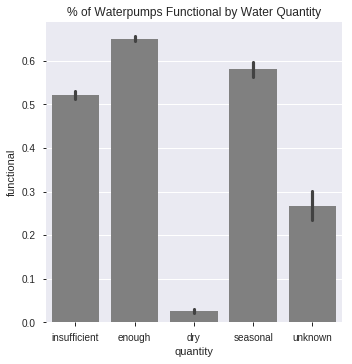

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

train['functional']= (train['status_group'] == 'functional').astype(int)
train[['status_group', 'functional']]

sns.catplot(x='quantity', y='functional', data=train, kind='bar', color='grey')
plt.title('% of Waterpumps Functional by Water Quantity')

## Do one-hot encoding & Scale features, 
within a complete model fitting workflow.

### Why and how to scale features before fitting linear models

Scikit-Learn User Guide, [Preprocessing data](https://scikit-learn.org/stable/modules/preprocessing.html)
> Standardization of datasets is a common requirement for many machine learning estimators implemented in scikit-learn; they might behave badly if the individual features do not more or less look like standard normally distributed data: Gaussian with zero mean and unit variance.

> The `preprocessing` module further provides a utility class `StandardScaler` that implements the `Transformer` API to compute the mean and standard deviation on a training set. The scaler instance can then be used on new data to transform it the same way it did on the training set.

### How to use encoders and scalers in scikit-learn
- Use the **`fit_transform`** method on the **train** set
- Use the **`transform`** method on the **validation** set


In [61]:
# Import package and scaler
import category_encoders as ce
from sklearn.preprocessing import StandardScaler

# use quantity feature and the numerical ffeatures but drop id
categorical_features = ['quantity']
numeric_features = X_train.select_dtypes('number').columns.drop('id').tolist()
features = categorical_features + numeric_features

# make subsets using the quantity feature all numeric features except id
X_train_subset = X_train[features]
X_val_subset = X_val[features]

# Do the encoding
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train_subset)
X_val_encoded = encoder.transform(X_val_subset)

# Use the scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_val_scaled = scaler.transform(X_val_encoded)

# Fit the model and check the accuracy
model = LogisticRegressionCV(n_jobs = -1)
model.fit(X_train_scaled, y_train)
print('Validation Accuracy', model.score(X_val_scaled, y_val))

Validation Accuracy 0.6585016835016835


### Compare original features, encoded features, & scaled features

### Get & plot coefficients

## Submit to predictive modeling competition


### Write submission CSV file

The format for the submission file is simply the row id and the predicted label (for an example, see `sample_submission.csv` on the data download page.

For example, if you just predicted that all the waterpoints were functional you would have the following predictions:

<pre>id,status_group
50785,functional
51630,functional
17168,functional
45559,functional
49871,functional
</pre>

Your code to generate a submission file may look like this: 
<pre># estimator is your scikit-learn estimator, which you've fit on X_train

# X_test is your pandas dataframe or numpy array, 
# with the same number of rows, in the same order, as test_features.csv, 
# and the same number of columns, in the same order, as X_train

y_pred = estimator.predict(X_test)


# Makes a dataframe with two columns, id and status_group, 
# and writes to a csv file, without the index

sample_submission = pd.read_csv('sample_submission.csv')
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('your-submission-filename.csv', index=False)
</pre>

### Send submission CSV file to Kaggle

#### Option 1. Kaggle web UI
 
Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file.


#### Option 2. Kaggle API

Use the Kaggle API to upload your CSV file.